In [1]:
# Start writing code here...

> Scott Lundberg paper: https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

In [2]:
import sys
sys.path.append('..')

import os
import shap
import pickle
import tempfile
import shap
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd

from  sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


import xgboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lib.supervised_tuning import  read_target_shifted_data
from lib.explainability import shap_deepnote_show, get_explainer_shap, get_kernel_explainer_shap, get_tree_explainer_shap, create_over_under_pred

%matplotlib inline


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [3]:
shap.initjs()

## Load numpy arrays and dataframes from pickle files

In [4]:
data_dir = "../assets/train_test_target_shifted/"
train_test_dict_file_name = "train_test_dict_target_shifted.pickle"
X_train_df_file_name = "X_train_impute_target_shifted_df.pkl"
X_test_df_file_name = "X_test_impute_target_shifted_df.pkl"

train_test_dict, X_train_impute_df, X_test_impute_df = read_target_shifted_data(
    data_dir, train_test_dict_file_name, X_train_df_file_name, X_test_df_file_name
)
X_train_impute = train_test_dict["X_train_impute"]
X_test_impute = train_test_dict["X_test_impute"]
X_pred_impute = train_test_dict["X_pred_impute"]

y_train_df = train_test_dict['y_train']
y_test_df = train_test_dict['y_test']
y_pred_df = train_test_dict['y_pred']


y_train = y_train_df['GSE_GWE_SHIFTED'].values.ravel()
y_test = y_test_df['GSE_GWE_SHIFTED'].values.ravel()
y_pred = y_pred_df['GSE_GWE_SHIFTED'].values.ravel()




#### Read Previously Stored models 

In [5]:
with open('../assets/models/supervised_learning_models/models.pickle', 'rb') as file:
        models = pickle.load(file)

In [6]:
for model in models:
    regressor_name = type(model.best_estimator_.regressor_).__name__ 
    y_pred_df[regressor_name] = model.best_estimator_.predict(X_pred_impute)
y_pred_df.drop(columns=[])

,,GSE_GWE_SHIFTED,XGBRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,CatBoostRegressor,RandomForestRegressor
TOWNSHIP_RANGE,YEAR,,,,,,,
T01N R02E,2021,NaN,56.801914,56.470355,114.458490,55.132342,55.936966,92.342528
T01N R03E,2021,NaN,32.689034,40.547124,64.270152,46.068579,30.619183,27.540840
T01N R04E,2021,NaN,19.502710,28.627116,60.111441,20.923116,21.654736,19.182664
T01N R05E,2021,NaN,26.481182,32.469002,79.537479,27.518669,23.568367,22.395348
T01N R06E,2021,NaN,39.996876,49.348293,156.758876,39.327920,35.367359,74.177929
...,...,...,...,...,...,...,...,...
T32S R26E,2021,NaN,199.522797,193.625010,206.672807,202.639403,196.930644,203.823184
T32S R27E,2021,NaN,130.441605,102.033365,159.778706,127.136327,123.554569,126.552513
T32S R28E,2021,NaN,198.805740,194.919167,192.071090,200.737654,189.598111,201.733590


### Explain the test predictions for which we have target data


In [7]:
y_pred_test_df = y_test_df.copy()
for model in models:
    regressor_name = type(model.best_estimator_.regressor_).__name__ 
    if regressor_name in ['SVR', 'RandomForestRegressor']:
        y_pred_test_df[regressor_name] = model.best_estimator_.predict(X_test_impute)

y_pred_test_svr = y_pred_test_df[['GSE_GWE_SHIFTED', 'SVR']]
y_pred_test_rf = y_pred_test_df[['GSE_GWE_SHIFTED', 'RandomForestRegressor']]

for df in [y_pred_test_svr, y_pred_test_rf]:
    for col in df.columns:
        if col != 'GSE_GWE_SHIFTED' : 
            df[f"{col}_diff"] = df[col] - df['GSE_GWE_SHIFTED']
            df.sort_values(by=[f'{col}_diff'], inplace=True)

The top and bottom rows of these dataframes indicate the greatest positive under-prediction and greatest over-predictions of the test data. We can dig into what the SHAP explainability informs us about the features in these rows.

In [8]:
#https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c

### Explainability through SHAP  

- For every model, pick an instance to explain feature importance

RandomForestRegressor


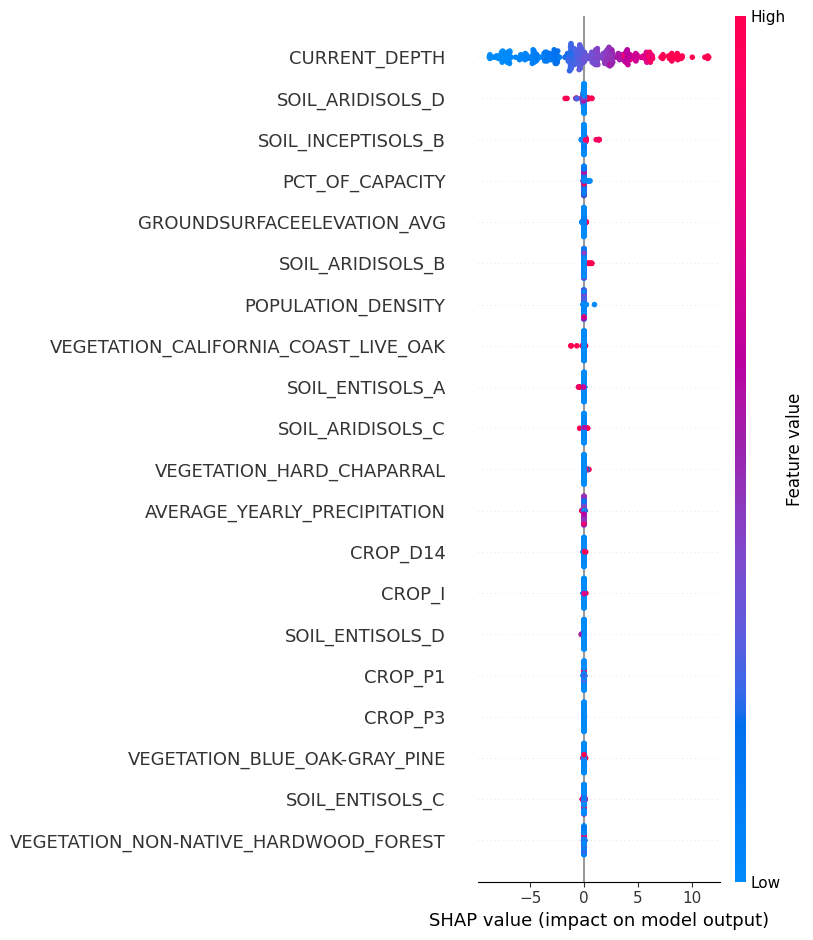

In [9]:


rf_explainer, rf_shap_values = get_explainer_shap(model = models[5].best_estimator_.regressor_, data = X_test_impute_df)
shap.summary_plot(rf_shap_values, X_test_impute_df)

In [10]:

model = models[1].best_estimator_.regressor_
sample = shap.sample(X_test_impute_df, 25)
svr_explainer,svr_shap_values  = get_kernel_explainer_shap (model, sample)


SVR


  0%|          | 0/25 [00:00<?, ?it/s]

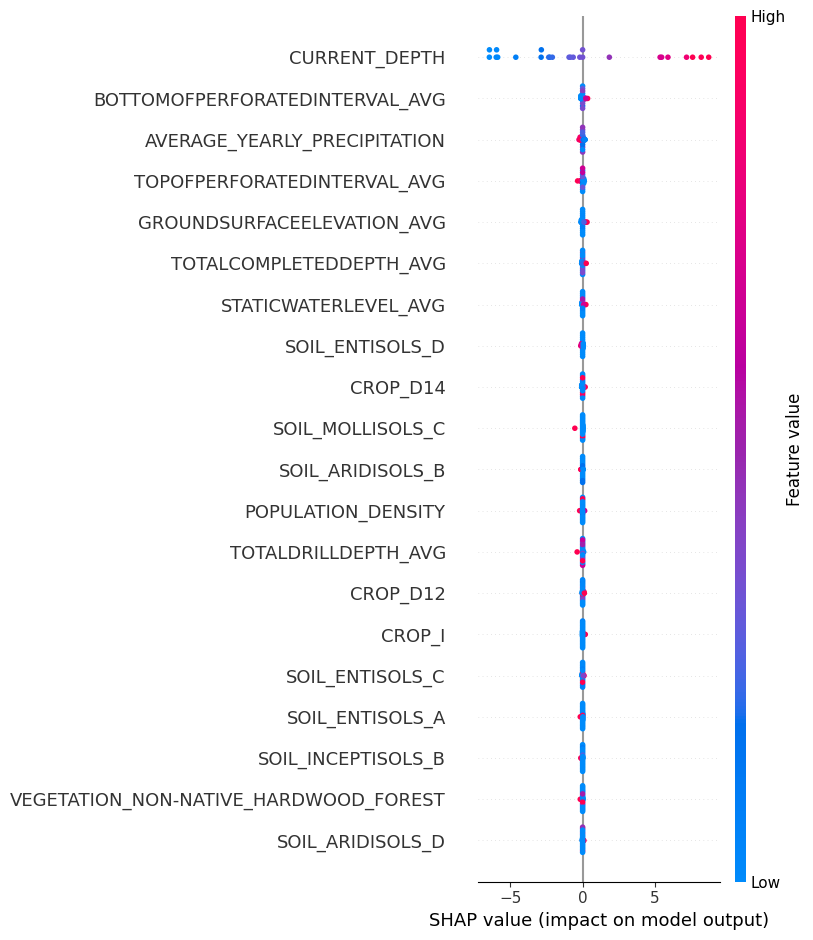

In [11]:
shap.summary_plot(svr_shap_values, sample)


https://www.kaggle.com/code/vikumsw/explaining-random-forest-model-with-shapely-values/notebook

### Difference in feature importance 
-  Random Forest Regressor and Support Vector Regressor

In [12]:
create_over_under_pred(models[1], y_pred_test_svr, svr_explainer, X_test_impute_df)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Model : SVR under prediction


Model : SVR under prediction


In [13]:
create_over_under_pred(models[5], y_pred_test_rf, rf_explainer, X_test_impute_df)

Model : RandomForestRegressor under prediction


Model : RandomForestRegressor under prediction


SHAP (SHapley Additive exPlanation) values attribute to each feature the change in the
expected model prediction when conditioning on that feature. They explain how to get from the
base value E[f(z)] that would be predicted if we did not know any features to the current output
f(x). These diagrams shows a single ordering. When the model is non-linear or the input features are not independent, however, the order in which features are added to the expectation matters, and the SHAP values arise from averaging the φi values across all possible orderings.

Predicted value in under prediction (scaled) is 13.50, while base value is 11.9 . Predicted value in over prediction (scaled) is 20.76, while base value is 11.9 

From the RandomForestRegressor, over and under prediction values, it appears that while current depth is the highest contributor to the determination of the target depth, the under prediction is boosted by the soil aridisols feature by a scaled value of -1.58 and GroundSurfaceElevation. The over prediction on the other hand is almost completely contrubuted to (not necessarily caused) by the high current depth value of 8.682 (scaled). 

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>